# **MSE 446 Final Project: Group 8**

## Project Recap

This project focuses on building a **machine learning classifier** to predict the **theme (or "tag") of a Commander deck** in *Magic: The Gathering* based on the properties of a new commander card. By extracting structured data from the [Scryfall](https://scryfall.com/) and [EDHRec](https://edhrec.com/) APIs, we will build a supervised learning pipeline that learns associations between card features (such as color identity, oracle text, and mana cost) and known deck archetypes. This can help MTG players more quickly and accurately place new commanders into viable deck strategies.


In [1]:
# =========================================
# 1) SETUP AND IMPORTS
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

import time
import csv
import requests
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical



2025-04-04 09:30:11.125211: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 09:30:11.277824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743773411.334636    5067 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743773411.350644    5067 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743773411.478061    5067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# =========================================
# 2) DATA RETRIEVAL
# =========================================

def convert_to_int(value):
    try:
        return int(value)
    except (ValueError, TypeError):
        return 0

# csv file creation
scryfall_csv_file = "all_together_output.csv"
card_info_columns = ["Name", "Type", "CMC", "Color Identity", "Oracle Text", "Keywords", "Power", "Toughness", "theme_label"]

edhrec_csv_file = "commander_cards_w_tag.csv"
tag_info_columns = ["Name", "Tag", "Num Decks"]

non_matches_file = "non_matching_commander_cards.csv"
non_matching_columns = ["Name", "Type", "CMC", "Color Identity", "Oracle Text", "Keywords", "Power", "Toughness"]

# open file/create if not existing
with open(scryfall_csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=card_info_columns)
    writer.writeheader()

with open(edhrec_csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=tag_info_columns)
    writer.writeheader()

with open(non_matches_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=non_matching_columns)
    writer.writeheader()

# START OF EDHREC FETCH #

# EDHREC URL for API requests (may need to change?)
url_base = "https://json.edhrec.com/pages/tags.json"

# get tag URL data
response = requests.get(url_base)
if response.status_code != 200:
    print(f"Failed to fetch data: {response.status_code} - {response.text}")
else:
    print(f"Fetched tag data")

try:
    data = response.json()
except ValueError as e:
    print(f"Failed to decode JSON: {str(e)} - {response.text}")

# list of tags
tag_urls = []
tag_data = data['container']['json_dict']['cardlists'][0]['cardviews']
for tag in tag_data:
    tag_urls.append(tag['url'])

# edhrec requests a delay so we dont get IP banned of around 200-500 ms
time.sleep(0.400) # 400 ms delay

print(tag_urls)
print("Completed tag fetching")

# create a dict of commanders -> (top tag, num_decks)
commanders = {}
tag_url_idx = 0

while True:

    tag_short_url = tag_urls[tag_url_idx]
    tag_url = "https://json.edhrec.com/pages" + str(tag_short_url) + ".json"
    tag_url_idx += 1

    # reached the end of the list
    if (tag_url_idx == len(tag_urls)):
        break

    print(f"Fetching from {tag_url}...")

    response = requests.get(tag_url)
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        break
    else:
        print(f"Fetched data from {tag_url}")

    try:
        data = response.json()
    except ValueError as e:
        print(f"Failed to decode JSON: {str(e)} - {response.text}")
        break

    # get name of tag
    tag_name = data['container']['breadcrumb'][1][tag_short_url]
    print(f"Parsing commander data for tag {tag_name}...")

    # get commander data, i.e., names of all commanders under this tag
    commander_data = data['container']['json_dict']['cardlists'][0]['cardviews']
    for commander in commander_data:
        name = str(commander['name'])
        new_num_decks = commander['num_decks']
        # Check if there is an existing entry with a higher num_decks
        if name in commanders.keys():
            curr_num_decks = commanders[name][1]
            # Overwrite the existing if the num_decks value is higher
            if (new_num_decks > curr_num_decks):
                print(f"Overwriting {name}'s old num_decks of {commanders[name][0]},{curr_num_decks} with {tag_name}, {new_num_decks}")
                commanders[name] = (tag_name, new_num_decks)
        # Simply add the new commander if not
        else:
            commanders[name] = (tag_name, new_num_decks)

    # edhrec requests a delay so we dont get IP banned of around 200-500 ms
    time.sleep(0.400) # 400 ms delay

# Write the commanders to CSV for now
with open(edhrec_csv_file, mode='a', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=tag_info_columns)
    for commander in commanders.keys():
        new_row = {
            "Name": commander,
            "Tag": commanders[commander][0],
            "Num Decks": commanders[commander][1]
        }
        writer.writerow(new_row)

# END OF EDHREC FETCH

# START OF SCRYFALL FETCH + CSV WRITING #

# scryfall URL for API requests (may need to change?)
url_base = "https://api.scryfall.com/cards/search"
# parameters for search on scryfall
search_params = {
    "q": "is:commander",
    "order": "name",
    "page": 1,
}

while True:
    response = requests.get(url_base, params=search_params)
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        break

    try:
        data = response.json()
    except ValueError as e:
        print(f"Failed to decode JSON: {str(e)} - {response.text}")
        break

    for card in data['data']:
        type_parts = card["type_line"].split(' — ') # remove Legendary Creature -
        relevant_type = type_parts[1] if len(type_parts) > 1 else "No Subtype"
        normalized_name = unidecode(card["name"])

        tag = ""
        # get tag from tag database
        if card["name"] in commanders.keys():
            tag = commanders[card["name"]][0]

            card_info = {
                "Name": normalized_name,
                "Type": relevant_type,
                "CMC": card["cmc"],
                "Color Identity": ", ".join(card["color_identity"]) if card["color_identity"] else "No Color Identity",
                "Oracle Text": card.get("oracle_text", "Missing Oracle Text").replace('\n', ''),
                "Keywords": ", ".join(card.get("keywords", [])),
                "Power": convert_to_int(card.get("power", 0)),
                "Toughness": convert_to_int(card.get("toughness", 0)),
                "theme_label": tag,
            }

            # now write it to csv
            with open(scryfall_csv_file, mode='a', newline='', encoding='utf-8') as file:
                writer = csv.DictWriter(file, fieldnames=card_info_columns)
                writer.writerow(card_info)

        else:
            # add to the no_match file
            card_info = {
                "Name": normalized_name,
                "Type": relevant_type,
                "CMC": card["cmc"],
                "Color Identity": ", ".join(card["color_identity"]) if card["color_identity"] else "No Color Identity",
                "Oracle Text": card.get("oracle_text", "Missing Oracle Text").replace('\n', ''),
                "Keywords": ", ".join(card.get("keywords", [])),
                "Power": convert_to_int(card.get("power", 0)),
                "Toughness": convert_to_int(card.get("toughness", 0)),
            }

            # now write it to csv
            with open(non_matches_file, mode='a', newline='', encoding='utf-8') as file:
                writer = csv.DictWriter(file, fieldnames=non_matching_columns)
                writer.writerow(card_info)

    # scryfall requests a delay so we dont get IP banned of around 50-100 ms
    time.sleep(0.075) # 75 ms delay

    # iterate to the next page
    if "next_page" in data:
        search_params["page"] += 1
    else:
        break
print("Completed commander card fetching")


Here we load the dataset from `all_together_output.csv` containing Magic: The Gathering card data.
- Displays the first 5 rows showing card attributes like `Name`, `Type`, `CMC`, `Oracle Text`, `Keywords`, `Power`, `Toughness`, and `theme_label`.

Key columns:
- `Oracle Text`: Flavor/ability text (important for theme classification)
- `theme_label`: Target variable (e.g., "Insects", "Chaos", "Elves")

In [2]:
# =========================================
# 3) DATA LOADING & INSPECTION
# =========================================

# Load the CSV file containing the card data.
data_file = 'all_together_output.csv'
df = pd.read_csv(data_file)

print("Data Sample:")
display(df.head())

print("Data Info:")
display(df.info())

Data Sample:


,Name,Type,CMC,Color Identity,Oracle Text,Keywords,Power,Toughness,theme_label
0,"Aatchik, Emerald Radian",Insect Druid,6.0,"B, G","When Aatchik enters, create a 1/1 green Insect...",NaN,3,3,Insects
1,Abaddon the Despoiler,Astartes Warrior,5.0,"B, R, U",TrampleMark of Chaos Ascendant — During your t...,"Mark of Chaos Ascendant, Trample",5,5,Chaos
2,Abomination of Llanowar,Elf Horror,3.0,"B, G",Vigilance; menace (This creature can't be bloc...,"Vigilance, Menace",0,0,Elves
3,"Aboshan, Cephalid Emperor",Octopus Noble,6.0,U,Tap an untapped Octopus you control: Tap targe...,NaN,3,3,Cephalids
4,"Abuelo, Ancestral Echo",Spirit,3.0,"U, W","Flying, ward {2}{1}{W}{U}: Exile another targe...","Flying, Ward",2,2,Blink


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            1568 non-null   object 
 1   Type            1568 non-null   object 
 2   CMC             1568 non-null   float64
 3   Color Identity  1568 non-null   object 
 4   Oracle Text     1559 non-null   object 
 5   Keywords        953 non-null    object 
 6   Power           1568 non-null   int64  
 7   Toughness       1568 non-null   int64  
 8   theme_label     1568 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 110.4+ KB


None

## **Class Filtering**

In this step, we filter out classes (i.e., labels in the theme_label column) that have fewer than 7 examples in the dataset.

When performing tasks like classification, especially with stratified splitting (ex: train_test_split with stratify), it's important that each class has enough number of examples.

Classes with very few samples can:
- Cause errors during stratified splitting (some classes may not appear in both train/test sets).
- Lead to unreliable or unstable model training and evaluation.
- Introduce noise or bias in model performance metrics.


In [3]:
# =========================================
# 4) FILTERING CLASSES WITH TOO FEW EXAMPLES
# =========================================

# For reliable stratification, filter out classes with fewer than 7 samples.
label_counts = df['theme_label'].value_counts()
valid_labels = label_counts[label_counts >= 7].index
df_filtered = df[df['theme_label'].isin(valid_labels)]

print("Filtered class distribution (classes with >= 7 examples):")
print(df_filtered['theme_label'].value_counts())


Filtered class distribution (classes with >= 7 examples):
theme_label
Artifacts        21
Tokens           21
Spellslinger     20
Treasure         20
Auras            19
                 ..
Keywords          7
Treefolk          7
Planeswalkers     7
Goad              7
Slivers           7
Name: count, Length: 88, dtype: int64


# **Train/Test/Validation Split**

In this step, we split the filtered dataset into training, validation, and test sets to prepare for model development and evaluation.

 - Training set: Used to fit the model.

 - Validation set: Used to tune hyperparameters and avoid overfitting.

 - Test set: Used only at the end to evaluate how well the model generalizes to new, unseen data.

By maintaining a clean separation between these sets we can ensures fair and unbiased performance evaluation.

In [4]:
# =========================================
# 5) TRAIN/TEST/VALIDATION SPLIT
# =========================================

# Drop the "Name" column since it is not used for training.
X = df_filtered.drop(columns=['Name', 'theme_label'])
y = df_filtered['theme_label']

# First split: 70% train, 30% temporary (for further splitting)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: Split temporary set into 50% validation and 50% test (~15% each overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 696
Validation set size: 149
Test set size: 150


## **Preprocessing Pipeline Setup**

In this step, we create a preprocessing pipeline using scikit-learn's Pipeline and ColumnTransformer. This setup helps us encode the data before feeding them into a machine learning model.

`MultiplyTransformer` is a custom transformerthat multiplies the output of another transformation by a scalar. This allows us to upweight certain features during model training, such as "Oracle Text" and "Type" since they likely carry more predictive value.

Below are the data columns and the type of encoding we used accordingly:

- `Oracle Text`: A descriptive column likely containing rules or abilities — needs text processing.
    -  We used TF-IDF to process the text  because it transforms text into numeric form based on term frequency-inverse document frequency, giving more weight to significant terms.

- `Type`: A single categorical variable like "Creature", "Sorcery" — needs OneHotEncoding and is upweighted.
    - We used OneHotEncoding because it treats each category as distinct and avoids any implication of relationships, which is good for types.

- `Color Identity` & `Keywords`: Also categorical but less critical — OneHotEncoding but not upweighted.

- `CMC`, `Power`, `Toughness`: Numerical features — will be scaled.
    - We used StandardScaler which normalizes the numeric values to have zero mean and unit variance.
    - This is because features like cmc, power or toughness might be on different scales and a lot of ML models are sensitive to this.

In [5]:
# =========================================
# 6) PREPROCESSING PIPELINE SETUP
# =========================================

# Define a custom transformer to multiply outputs by a factor.
class MultiplyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.0):
        self.factor = factor
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X * self.factor

# Define columns:
# We want to upweight "Oracle Text" and "Type" features.
text_column = 'Oracle Text'
cat_type_column = 'Type'
cat_other_columns = ['Color Identity', 'Keywords']
numeric_columns = ['CMC', 'Power', 'Toughness']

# Pipeline for Oracle Text with upweighting.
text_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('flatten', FunctionTransformer(lambda x: x.ravel(), validate=False)),
    ('tfidf', TfidfVectorizer()),
    ('multiply', MultiplyTransformer(factor=2.0))  # Upweight Oracle Text
])

# Pipeline for the "Type" column with upweighting.
cat_type_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('multiply', MultiplyTransformer(factor=2.0))  # Upweight Type
])

# Pipeline for other categorical features.
cat_other_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for numeric features.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine pipelines into a ColumnTransformer.
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_pipeline, [text_column]),
        ('cat_type', cat_type_pipeline, [cat_type_column]),
        ('cat_other', cat_other_pipeline, cat_other_columns),
        ('num', num_pipeline, numeric_columns)
    ]
)


## **Model Pipeline Setup**

For our model pipeline, we used the preprocessing pipeline we created earlier to transform and handle the feature data as well as a random forest classifier as the final step.

The `RandomForestClassifier` uses 100 trees in the forest and a fixed random seed for splitting and model training. 

Lastly `fit()` uses the training data `X_train` and the labels corresponding to the data `y_train` to apply the preprocessing steps and fit the classifier to the transformed data.


In [17]:

# =========================================
# 7) MODEL PIPELINES & TRAINING
# =========================================

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the Random Forest pipeline.
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('flatten',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f392e60eac0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('multiply',
                                                                   MultiplyTransformer(factor=2.0))]),
                                                  ['Oracle Text']),
                                                 ('cat_type',
                                                  Pipeline(steps=[('imputer...
                                                  ['Type']),
                                                 ('cat_other',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Color Identity',
                                                   'Keywords']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CMC', 'Power',
                                                   'Toughness'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

## **Deep Learning Model**

Our code sets up and trains a deep learning model for classification using Keras. It performs the following steps:

1. Data Preprocessing:

    - The training, validation, and test datasets are preprocessed using a previously defined `preprocessor`, which applies transformations such as encoding of category variables, and scaling of numeric features.

2. Label Encoding:

    - The target labels (`y_train`, `y_val`, `y_test`) are converted to integer format using LabelEncoder and then further one-hot encoded using to_categorical. This is important for multi-class classification, since the models expect the target in a one-hot encoded form.

3. Model Architecture:

    - A Sequential model is defined with the following layers:
        - Dense layers with ReLU activation functions, where each layer has L2 regularization to prevent overfitting.
        - BatchNormalization layers are included after each dense layer to stabilize learning by normalizing activations.
        - Dropout layers (rate of 0.5) are applied to reduce overfitting by randomly setting a fraction of the inputs to zero during training.
        - The final output layer uses softmax activation to predict the class probabilities for each of the possible classes.

4. Model Compilation:

    - The model is compiled using the Adam optimizer, categorical cross-entropy loss, and accuracy as the evaluation metric.

5. Training:

    - The model is trained for 20 epochs using a batch size of 16, with the training data (`X_train_transformed`, `y_train_cat`) and validation data (`X_val_transformed`, `y_val_cat`).
    - We also use the `ReduceLROnPlateau` callback to reduce the learning rate by a factor of 0.5 if the validation loss does not improve for 2 consecutive epochs, ensuring better convergence.

6. Visualization:

    - After training, we plot the training and validation accuracy so that it is easy for us to visualize the model's performance and whether it is underfitting/overfitting.

Epoch 1/20


/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/prab/miniconda3/envs/mse4

44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.0107 - loss: 5.2998 - val_accuracy: 0.0134 - val_loss: 4.4893 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0101 - loss: 4.8577 - val_accuracy: 0.0134 - val_loss: 4.4919 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 408ms/step - accuracy: 0.0313 - loss: 4.6758 - val_accuracy: 0.0134 - val_loss: 4.4875 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 587ms/step - accuracy: 0.0525 - loss: 4.3849 - val_accuracy: 0.0134 - val_loss: 4.4757 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 401ms/step - accuracy: 0.0582 - loss: 4.1900 - val_accuracy: 0.0201 - val_loss: 4.4448 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 318ms/step - accuracy: 0.0853 - loss: 4.0685 - val_accuracy: 0.0336 - val_loss: 4.3980 - learning_rate: 0.0010
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.1267 - loss: 3.8639 - val_accura

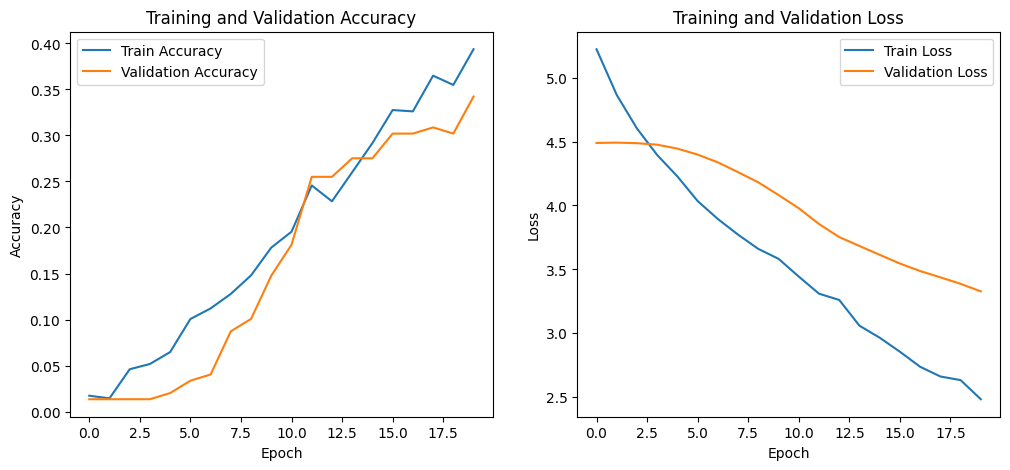

In [11]:
# =========================================
# 8) DEEP LEARNING MODEL
# =========================================

# Transform features for deep learning.
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed   = preprocessor.transform(X_val)
X_test_transformed  = preprocessor.transform(X_test)

# Encode labels as integers.
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
input_dim = X_train_transformed.shape[1]

# One-hot encode labels.
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# Build the deep learning model.
dl_model = Sequential([
    Dense(256, activation='relu', input_dim=input_dim,
          kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

dl_model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Define callback: ReduceLROnPlateau (no EarlyStopping)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# Train deep learning model.
history = dl_model.fit(
    X_train_transformed, y_train_cat,
    validation_data=(X_val_transformed, y_val_cat),
    epochs=20,
    batch_size=16,
    callbacks=[reduce_lr]
)

# Plot training & validation accuracy and loss curves.
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


## **Visualization**

Here we evaluate the models performance on the test set and focus analysis on the top 30 most frequent classes for a better understanding.

We provide both quantitative metrics (accuracy, classification report) and visual insight (confusion matrix heatmap) into how the model performs in real predictions.

/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prab/min

Test Accuracy of Best Model: 0.5267

Classification Report (Test Set - Top 30 Classes):
                precision    recall  f1-score   support

        Wheels       0.00      0.00      0.00         3
       Dragons       0.60      1.00      0.75         3
      Treasure       0.25      0.67      0.36         3
          Mill       1.00      0.33      0.50         3
         Blink       0.75      1.00      0.86         3
     Artifacts       0.38      1.00      0.55         3
        Angels       0.60      1.00      0.75         3
  Spellslinger       0.25      0.33      0.29         3
        Tokens       0.50      0.67      0.57         3
  Lands Matter       0.67      0.67      0.67         3
       Discard       1.00      0.67      0.80         3
      Lifegain       0.50      0.67      0.57         3
       Goblins       0.40      0.67      0.50         3
+1/+1 Counters       0.29      0.67      0.40         3
     Equipment       0.50      0.67      0.57         3
       Spirits 

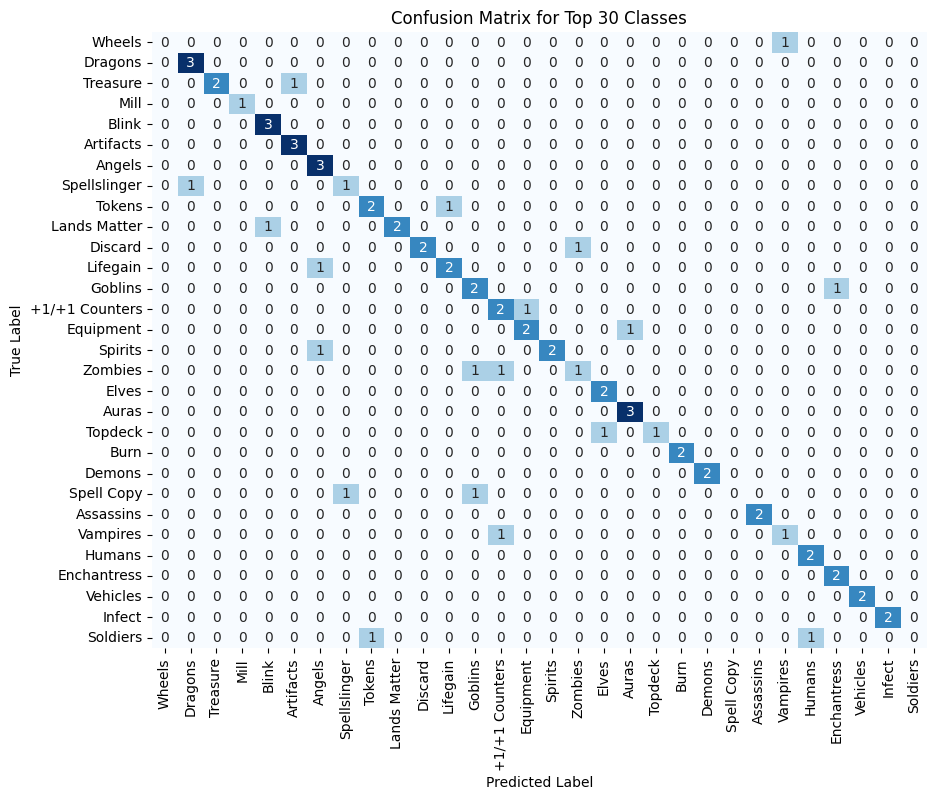

In [ ]:
# =========================================
# 9) VISUALIZATIONS: SIMPLIFIED CONFUSION MATRIX & CLASSIFICATION
# =========================================

# For demonstration, we use the Random Forest pipeline's predictions.
best_pipeline = rf_pipeline
y_test_pred = best_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy of Best Model: {test_acc:.4f}")

# Determine the top 30 most frequent classes in the test set.
class_counts = collections.Counter(y_test)
top_30_classes = [label for label, count in class_counts.most_common(30)]

# Print a classification report for the top 30 classes.
print("\nClassification Report (Test Set - Top 30 Classes):")
print(classification_report(y_test, y_test_pred, labels=top_30_classes))

# Compute the confusion matrix for only the top 30 classes.
cm = confusion_matrix(y_test, y_test_pred, labels=top_30_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=top_30_classes, yticklabels=top_30_classes, cbar=False)
plt.title("Confusion Matrix for Top 30 Classes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## **Prediction Function**

The function `predict_theme` provides a way to predict the theme label for a new card input. It takes a dictionary representing the card's features (ex: type, color identity, oracle text etc.) and returns a predicted theme label. This abstraction makes it easy for users to query the model without having to understand the background preprocessing or model logic. 

The function also has a `model_choice` parameter which allows users to switch between:

- `dl`: a trained deep learning model, which takes transformed numeric input and outputs a probability distribution over classes. The function decodes the predicted class index back into a label using the LabelEncoder.

- `rf`: a Random Forest pipeline, which has its own preprocessing steps internally and outputs predicted labels directly.

In [16]:
# =========================================
# 10) INTERACTIVE PREDICTION FUNCTION (USING EITHER MODEL)
# =========================================

def predict_theme(input_data, model_choice="dl"):
    """
    Given a dictionary with keys:
      "Type", "CMC", "Color Identity", "Oracle Text", "Keywords", "Power", "Toughness",
    this function returns the predicted theme label.
    
    Parameters:
      input_data: dict containing the feature values.
      model_choice: str, either "dl" for deep learning model or "rf" for Random Forest pipeline.
      
    Returns:
      The predicted theme label as a string.
    """
    # Convert the dictionary into a one-row DataFrame.
    df_input = pd.DataFrame([input_data])
    
    if model_choice == "dl":
        # Use the deep learning model:
        X_input = preprocessor.transform(df_input)
        pred_prob = dl_model.predict(X_input)
        pred_class = pred_prob.argmax(axis=1)
        predicted_theme = label_encoder.inverse_transform(pred_class)
        return predicted_theme[0]
    elif model_choice == "rf":
        # Use the Random Forest pipeline; note that rf_pipeline already includes the preprocessor.
        predicted_theme = rf_pipeline.predict(df_input)
        return predicted_theme[0]
    else:
        raise ValueError("model_choice must be either 'dl' for deep learning or 'rf' for Random Forest.")

# Example usage:
sample_input = {
    "Type": "Insect Druid",
    "CMC": 6.0,
    "Color Identity": "B, G",
    "Oracle Text": ("When Aatchik enters, create a 1/1 green Insect creature token for each artifact and/or "
                    "creature card in your graveyard. Whenever another Insect you control dies, put a +1/+1 counter "
                    "on Aatchik. Each opponent loses 1 life."),
    "Keywords": "",
    "Power": 3,
    "Toughness": 3
}

# Predict using the deep learning model (default)
predicted_label_dl = predict_theme(sample_input, model_choice="dl")
print("Predicted theme (Deep Learning):", predicted_label_dl)

# Predict using the Random Forest model
predicted_label_rf = predict_theme(sample_input, model_choice="rf")
print("Predicted theme (Random Forest):", predicted_label_rf)

print("Notebook execution complete.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted theme (Deep Learning): Insects
Predicted theme (Random Forest): Insects
Notebook execution complete.


/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/prab/miniconda3/envs/mse446/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/prab/miniconda3/envs/mse4

## 🎉 **Conclusion**
This project aimed to predict Magic: The Gathering Commander deck themes using machine learning. By combining structured card data (e.g., color identity, mana cost, oracle text) with supervised learning, we built a pipeline to classify new commanders into archetypes.

We learned that:
 - Text features like oracle text are crucial and benefit from NLP techniques (e.g., TF-IDF).

 - Pipelines, EDA, and evaluation metrics are key to successful data analytics.

 - Data pipelines are essential: Using ColumnTransformer and Pipeline helped us streamline preprocessing and model training, making experimentation much faster.

 - Data analysis helped us set the foundation: Initial visualizations and data summaries informed many of our later modeling decisions.

 - Model evaluation is multidimensional: Accuracy alone wasn't enough so we also relied on classification reports and confusion matrices to spot overfitting or poor class performance.

 - APIs and data wrangling matter: Gathering and cleaning data from live APIs showed us how critical it is to understand your sources and data structure before modeling. (we suffered here)

 - Data preprocessing and thoughtful feature engineering greatly influence performance.


To continue this project in the future, we suggest:

 - Expanding the dataset with more commanders and user-generated decks.

 - Applying advanced NLP models (like BERT) for better text understanding.

 - Exploring ensemble or deep learning models.

 - Building a web app to predict deck tags from user input.

 - Using model explainability tools (ex: SHAP) to interpret predictions.